## Mô tả bài toán (input, output)

Đây là bài toán sử dụng các thông số, thương hiệu, ... của mặt hàng để đưa ra dự đoán giá của sản phẩm.

### Import dữ liệu

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import re
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Giải nén dữ liệu

In [ ]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!unzip -n /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
!unzip -n /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip

### Đọc dữ liệu

<br> Input của bài toán là tập "train.tsv" và "test.tsv". </br>

In [ ]:
train = pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test_stg2.tsv", sep="\t")

In [ ]:
train.head(5)

In [ ]:
test.head(5)

Trong đó:
* train_id, test_id là số id của các sản phẩm
* name là tên sản phẩm
* item_condition_id là id tình trạng của sản phẩm được cung cấp bởi người bán
* category_name là phân loại sản phẩm
* brand_name là tên thương hiệu
* price là giá trị của sản phẩm. Là mục tiêu của bài toán của chúng ta, đơn vị: USD.
* shipping biểu thị cho người trả phí tiền ship được biểu thị bởi 0 (buyer - người mua) và 1 (seller - người bán)
* item_description là mô tả chi tiết sản phẩm

## Phân tích dữ liệu, convert, clean dữ liệu

### Mô tả đầu vào

Liệt kê các cột và thông tin của các cột từ đầu vào

In [ ]:
train.columns

In [ ]:
test.columns

In [ ]:
train.info()

Bộ "train":
* Có 3 cột thuộc tính int64, 1 cột thuộc tính float64, 3 cột thuộc tính object.
* Trong số 8 cột, chỉ có 5 cột là có đầy đủ data.
* Có 3 cột có data trống là: category_name, brand_name và item_description.
* Cột brand_name có rất nhiều ô bỏ trống.
* Các cột bị thiếu dữ liệu đều có định dạng là string, nên được thay thế bằng một cụm string khác. VD: "missing".

In [ ]:
test.info()

Bộ "test" cũng giống như bộ "train" trừ cột price, đây là cột phải đoán giá của sản phẩm từ bài toán.

<br> Tập dữ liệu "train.tsv" bao gồm 1482535 entries (sản phẩm), mỗi sản phẩm gồm các cột thuộc tính như: tên sản phẩm, phân loại sản phẩm, giá sản phẩm, shipping id và mô tả sản phẩm. </br>
<br> Tập dữ liệu "test.tsv" bao gồm 3460725 entries (sản phẩm), mỗi sản phẩm gồm các cột thuộc tính như: tên sản phẩm, phân loại sản phẩm, shipping id và mô tả sản phẩm. </br>
Qua bước đọc dữ liệu đầu vào, ta có thể rút ra những điều cần làm như sau:
* Cột category_name có 3 phần, có thể chia ra thành 3 cột riêng.
* Các cột category_name, brand_name và item_description có dữ liệu trống nên cần phải có bước (fillnull) thay thế bằng một string khác để xử lý dữ liệu.
* Nếu tập dữ liệu có các hàng trùng lặp, cần phải có bước xóa bỏ tránh trùng dữ liệu giữa các hàng.
* Cột price có những giá trị có thể lớn hơn hoặc bằng 0, cần phải xử lý.
* Cột price có thể sử dụng phép toán log để giảm thiểu sự chênh lệch về giá và làm output cho bài toán hồi quy.

### Phân tích dữ liệu

Ta sẽ tiến hành kiểm tra dữ liệu dựa trên các cột của bộ dữ liệu ban đầu.

**Kiểm tra các tập dữ liệu bị trống**

In [ ]:
# Amount of missing values in both train and test datasets (by Number)
missing_data = pd.DataFrame({'train_missing': train.drop(["train_id", "price"], axis=1).isnull().sum(), 'test_missing': test.drop(["test_id"], axis=1).isnull().sum() })
missing_data

In [ ]:
# Amount of missing values in both train and test datasets (by Percentage)
df = pd.concat([train.drop(["train_id", "price"], axis=1).isna().sum(), test.drop(["test_id"], axis=1).isna().sum()], axis=1)
df.columns = ["Train", "Test"]

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(16,6))

i=0
fig.set_facecolor('white')
for r in np.arange(1):
    for c in np.arange(6):
        explode = (0, 0.1)
        axs[r, c].pie([len(train)-df.iloc[i]["Train"], df.iloc[i]["Train"]], 
                      labels=["Filled\nvalues", "Missing\nvalues"],
                      explode=explode, autopct="%1.1f%%", labeldistance=1.2,
                      colors=["teal", "salmon"], startangle=55)
        axs[r+1, c].pie([len(test)-df.iloc[i]["Test"], df.iloc[i]["Test"]], 
                      labels=["Filled\nvalues", "Missing\nvalues"],
                      explode=explode, autopct="%1.1f%%", labeldistance=1.2,
                      colors=["teal", "salmon"], startangle=55)
        axs[r, c].set_title("Train: " + df.index[i], pad=10)
        axs[r+1, c].set_title("Test: " + df.index[i], pad=10)
        i += 1
fig.suptitle("Amount of missing values in train and test datasets")
plt.show();

**Liệt kê top 5 các thông tin xuất hiện nhiều nhất về các cột như: name, brand_name, category_name, item_description**

In [ ]:
# Top 5 names in each dataset
train["name"].value_counts()[:5], test["name"].value_counts()[:5]

In [ ]:
# Top 5 index's name
top_name = Counter(list(train.name))
x,y = zip(*top_name.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 name')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Phần lớn các sản phẩm là Bundle, Reserved, Converse và Dress. Điều này cho thấy mối quan tâm của khách hàng và chủ đầu tư đến các sản phẩm quần áo bộ, giày, váy là nhiều như thế nào.

In [ ]:
# Top 5 brand names in each dataset
# Replace null value in brand_name column by "missing"
train.brand_name.fillna(value="missing", inplace=True)
test.brand_name.fillna(value="missing", inplace=True)
train["brand_name"].value_counts()[:5], test["brand_name"].value_counts()[:5]

In [ ]:
# Top 5 brand name
top_brand = Counter(list(train.brand_name))
x,y = zip(*top_brand.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 brand name')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Ta có thể thấy phần lớn các sản phẩm đều không có thương hiệu, và một số sản phẩm có thương hiệu đứng đầu như: PINK, Nike, Victoria's Secret, LuLaRoe, Apple đều là những thương hiệu nổi tiếng trên thế giới. Số liệu này cho thấy người dùng chỉ một phần quan tâm tới thương hiệu của sản phẩm, sự quan tâm của họ có lẽ sẽ phụ thuộc nhiều vào chi phí và chất lượng của sản phẩm nhiều hơn.

In [ ]:
# Top 5 category names
train["category_name"].value_counts()[:5], test["category_name"].value_counts()[:5]

In [ ]:
# Top 5 item descriptions in each dataset
train["item_description"].value_counts()[:5], test["item_description"].value_counts()[:5]

<br> Do phần category_name chứa 3 mục riêng biệt nên chúng ta sẽ xem xét mức độ phân bố của từng phần sau khi preprocess. </br>
Phần item_description do có chứa nhiều từ ngữ và dấu câu không đem lại hiệu quả trong việc biểu thị nghĩa của câu nên cũng sẽ xem xét sau khi preprocess.

**Item condition**

In [ ]:
# Item condition distribution
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Item condition')
sns.countplot(x='item_condition_id', data=train, ax=ax)

Phần lớn các sản phẩm đều có chỉ số condition từ 1-3. Lượng sản phẩm trong khoảng 4-5 rất ít. Nó cho thấy các sản phẩm tung ra hầu hết là mới và gần như mới. Có thể nhu cầu sử dụng đồ second hand của người dùng cũng khá nhiều, khi giá sản phẩm mới hoàn toàn khá là đắt đỏ và dùng đồ second hand có lẽ chất lượng không bằng nhưng vẫn chấp nhận vì giá thành rẻ hơn ban đầu.

**Price distribution**

In [ ]:
# Price distribution
fig, ax = plt.subplots(figsize=(14, 12))
ax.hist(train.price,bins = 50, range = [0,300],label="Price",color="sandybrown", edgecolor="black")
ax.set_title("Price distribution", fontsize=20, pad=5)
ax.set_xlabel('Price',fontsize=15)
ax.set_ylabel('Amount of items', fontsize=15)
ax.set_yticks(np.arange(0, 1000000, 100000))
ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)
ax.grid(axis="y")
ax.margins(0.05, 0.05)
plt.show()

<br> Phần lớn price của các sản phẩm này có giá trị từ 0-50. Ta có thể thấy sự phân bố không đồng đều của bộ dữ liệu. </br>
Vì vậy, thay vì đánh giá hàm price, ta sẽ xem xét hàm log(price).

**So sánh số lượng sản phẩm có phí ship được trả bởi khách hàng và người bán**

In [ ]:
# Shipping distribution
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Shipping')
sns.countplot(x='shipping', data=train, ax=ax)

Ta có thể thấy lượng sản phẩm có phí ship được người bán trả (0) nhiều hơn lượng sản phẩm có phí ship được trả bởi người mua (1). Có thể thấy, việc cửa hàng chi trả phí ship cũng là một phương thức tiếp cận khách hàng tốt đáng được chú trọng, điều này kích thích người mua có ý định mua hơn khi chưa nhìn tới giá thành của sản phẩm.

### Xử lý dữ liệu

**Chia cột category_name thành 3 phần**

In [ ]:
# Split category_name to first, second and third category
train[["first_category", "second_category", "third_category"]] = train["category_name"].str.split('/', 2, expand=True)
test[["first_category", "second_category", "third_category"]] = test["category_name"].str.split('/', 2, expand=True)
train.head(5)

In [ ]:
# Top 5 popular first category

# Remove null value
train.first_category.fillna(value="missing", inplace=True)
test.first_category.fillna(value="missing", inplace=True)
top = Counter(list(train.first_category))
x,y = zip(*top.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 first category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Ta có thể thấy, mục first_category đặc trưng cho loại sản phẩm nói chung: (VD như Women, Beauty, Kids, Electronics, Men). Trong đó, Women đứng đầu với 663988 lớn hơn mục thứ hai (Beauty với 207724). Từ đó cho thấy, phần lớn sản phẩm được hướng tới phụ nữ và cũng có thể hiểu là phụ nữ là đối tượng tiềm năng cho các nhà đầu tư hướng tới.

In [ ]:
# Top 5 popular first category
# Remove null value
train.second_category.fillna(value="missing", inplace=True)
test.second_category.fillna(value="missing", inplace=True)
top = Counter(list(train.second_category))
x,y = zip(*top.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 second category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Nhìn vào sơ đồ, second_category đặc trưng cho nhiều loại sản phẩm nói riêng có cùng một điểm chung (Athelic Apparel, Makeup, Top & Blouses, Shoes và Jeweiry). Các loại sản phẩm không có nhiều sự chênh lệch cho thấy sự đa dạng về loại và sự đồng đều của thị trường thế giới. 

In [ ]:
# Top 5 popular first category
# Remove null value
train.third_category.fillna(value="missing", inplace=True)
test.third_category.fillna(value="missing", inplace=True)
top = Counter(list(train.third_category))
x,y = zip(*top.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 third category')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Sơ đồ thứ ba, third_category thể hiện cho các loại sản phẩm nói riêng như: T-shirts, Shoes, ... Hầu như các sản phẩm đứng đầu đều hướng về trang phục, tuy nhiên, mục Pants, Tights, Leggings đứng đầu nhưng cũng chỉ chiếm 60152. Bởi vậy, ta càng thấy rõ được sự đa dạng và quyết định đúng đắn của các nhà đầu tư khi lựa chọn thị trường và kinh doanh sản phẩm hợp lý.

### Đánh giá chung
Qua bước phân tích dữ liệu, ta thấy được các thông số của sản phẩm ít nhiều ảnh hưởng tới giá thành của sản phẩm. Bởi vậy, bài toán đã cho hoàn toàn có khả năng có thể dự đoán được giá thành của một sản phẩm thông qua các thông số và các thông tin bên ngoài.

**Xử lý dữ liệu bị trống**

<br> Ta có thể thấy tập dữ liệu bị trống khá nhiều ở các cột:  category_name, brand_name và item_description. Ngoài ra còn có các cột category1,2,3 bị trống. Do vậy, ta cần tiến hành thay thế các giá trị trống đấy bằng giá trị hợp lý. </br>
Tuy nhiên, trong bộ dữ liệu "train", cột item_description bị trống khá ít (chỉ 4 hàng), nên ta có thể xóa 4 hàng này đi.

In [ ]:
# Replace null value by "missing" in "train" data
train.category_name.fillna(value="missing", inplace=True)
train.brand_name.fillna(value="missing", inplace=True)
train.item_description.fillna(value="missing", inplace=True)
train.first_category.fillna(value="missing", inplace=True)
train.second_category.fillna(value="missing", inplace=True)
train.third_category.fillna(value="missing", inplace=True)

In [ ]:
# Replace null value by "missing" in "test" data
test.category_name.fillna(value="missing", inplace=True)
test.brand_name.fillna(value="missing", inplace=True)
test.item_description.fillna(value="missing", inplace=True)
test.first_category.fillna(value="missing", inplace=True)
test.second_category.fillna(value="missing", inplace=True)
test.third_category.fillna(value="missing", inplace=True)

In [ ]:
# Remove 4 lines which item_description is misssing
train = train[train.item_description != 'missing'].reset_index(drop=True)

**Phân bố cột "item_description"**

In [ ]:
# Top 5 popular item description 
top = Counter(list(train.item_description))
x,y = zip(*top.most_common(5))
plt.figure(figsize=[6,5])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='black')
plt.gca().invert_yaxis()
plt.ylabel('Top 5 item description')
plt.xlabel('count')
plt.grid(False, axis='y')
plt.show()

Hầu hết sản phẩm đều chưa có mô tả.

**Xóa các dữ liệu bị trùng lặp**

In [ ]:
train.drop_duplicates(subset=None, keep='first', inplace=False)

Không có hàng dữ liệu nào bị trùng lặp

**Loại bỏ những hàng có price <= 0**

In [ ]:
# Remove rows with price <= 0
train = train[train.price > 0].reset_index(drop=True)

<br> Sau khi loại bỏ những hàng có price <= 0, ta có thể xem xét đánh giá log(price). </br>
**Phân bố hàm log(price)**

In [ ]:
sns.distplot(np.log1p(train['price']))

Ta có thể thấy, phân bố của hàm log(Price) khá đồng dạng với dạng phân phối chuẩn. Vì vậy, ta có thể sử dụng hàm log(price) làm output dự đoán cho bài toán.

In [ ]:
train['price'] = np.log1p(train['price'])

In [ ]:
train.head(5)

### Clean dữ liệu

**Xử lý các câu dài hoặc chứa những từ ngữ không mang ý nghĩa trong name và item_description**

Do có nhiều từ, ký tự không đem lại hiệu quả trong việc diễn đạt ý nghĩa của câu, ta có thể loại bỏ chúng để việc dự đoán đạt hiệu quả tốt nhất.
* Loại bỏ các dấu câu
* Loại bỏ một số từ ngắn (stopwords)

In [ ]:
# Import stopwords

stop_words = set(stopwords.words("english"))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

# Processing 
def processing_data(col):
    new_col = []
    for text in tqdm(col.values):
        # Remove [rm] tag
        text = text.replace('[rm]', '')
        # Remove single character between 2 words
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        # Remove stop words
        text = ' '.join(word for word in text.lower().split() if word not in stop_words)
        new_col.append(text.strip())
    return new_col;

In [ ]:
train['name'] = processing_data(train['name'])
test['name'] = processing_data(test['name'])

train['item_description'] = processing_data(train['item_description'])
test['item_description'] = processing_data(test['item_description'])

**Xem lại data sau khi preprocessing:**

In [ ]:
train.head(5)

### Vectorizes data

<br> Do các dữ liệu vẫn đang ở dạng text nên chúng ta cần chuyển chúng về dạng vector để xử lý tuyến tính.
Ta sử dụng thư viện vectorize văn bản là TfidfVectorizer cho các dữ liệu dạng văn bản là 'name' và 'item_description'. </br>
Trong khai phá dữ liệu văn bản (text mining), thuật ngữ TF-IDF (Term Frequency - Inverse Document Frequency) là một phương thức thống kê được biết đến rộng rãi nhất để xác định độ quan trọng của một từ trong đoạn văn bản trong một tập nhiều đoạn văn bản khác nhau. Nó thường được sử dụng như một trọng số trong việc khai phá dữ liệu văn bản. TF-IDF chuyển đổi dạng biểu diễn văn bản thành dạng không gian vector (VSM), hoặc thành những vector thưa thớt.
* TF: Term Frequency(Tần suất xuất hiện của từ) là số lần từ xuất hiện trong văn bản.
* IDF: Inverse Document Frequency(Nghịch đảo tần suất của văn bản), giúp đánh giá tầm quan trọng của một từ .
* Khi đó, ta thu được công thức tính hoàn chỉnh của TF-IDF là tích của giá trị TF và IDF.

\begin{align*}
\mathbf{tf}(t, d) = \frac{ \mathbf{f}(t, d)}{ max \{ \mathbf{f}(w, d) : w ∈ d \} }
\end{align*}

\begin{align*}
\mathbf{idf}(t, D) = \log{ \frac{|D|}{| \{d ∈ D : t ∈ d \} |}}
\end{align*}

\begin{align*}
\mathbf{tfidf}(t, d, D) = \mathbf{tf}(t, d) * \mathbf{idf}(t, D)
\end{align*}

Trong đó:
* tf(t, d): tần suất xuất hiện của từ t trong văn bản d
* f(t, d): Số lần xuất hiện của từ t trong văn bản d
* max({f(w, d) : w ∈ d}): Số lần xuất hiện của từ có số lần xuất hiện nhiều nhất trong văn bản d
* idf(t, D): giá trị idf của từ t trong tập văn bản
* |D|: Tổng số văn bản trong tập D
* |{d ∈ D : t ∈ d}|: thể hiện số văn bản trong tập D có chứa từ t.
* tfidf(t, d, D): trọng số để đánh giá tầm quan trọng của một từ t trong văn bản d trong tập D.

In [ ]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
# Vectorizer item_description 
train_des = tfidf.fit_transform(train['item_description'])
test_des = tfidf.transform(test['item_description'])

In [ ]:
count_vec = CountVectorizer()
# Vectorizer name
train_name = count_vec.fit_transform(train['name'])
test_name = count_vec.transform(test['name'])

In [ ]:
train_name.shape

In [ ]:
train_des.shape

### Label Binarize

Với các dữ liệu ở dạng Label, chúng ta cần biến đổi chúng thành một dạng số đại diện để có thể dễ dàng đưa vào input của model.
Chúng ta sử dụng thư viên LabelBinarize của sklearn.
LabelBinarize sẽ tạo ra một ma trận One-hot encoding. Thuật toán này sẽ tạo ra 1 cột boolean cho mỗi category. Mỗi giá trị chỉ có thể nhận một một giá trị riêng biệt. 
* Tức là một kỹ thuật biểu diễn một từ dưới dạng vector có dạng:
\begin{align*}
\mathbb{R}^{|V|x1}
\end{align*}


In [ ]:
test.head(5)

In [ ]:
# Label Binarizer
lb = LabelBinarizer(sparse_output=True)
# LB brand name
train_brand = lb.fit_transform(train['brand_name'])
test_brand = lb.transform(test['brand_name'])
# LB category
train_first = lb.fit_transform(train['first_category'])
test_first = lb.transform(test['first_category'])
train_second = lb.fit_transform(train['second_category'])
test_second = lb.transform(test['second_category'])
train_third = lb.fit_transform(train['third_category'])
test_third = lb.transform(test['third_category'])
# LB item condition id
train_item_condition_id = lb.fit_transform(train['item_condition_id'])
test_item_condition_id = lb.transform(test['item_condition_id'])
# LB shipping
train_shipping = lb.fit_transform(train['shipping'])
test_shipping = lb.transform(test['shipping'])

### Merge các vector bằng hstack

Ghép các dữ liệu trên vào một ma trận để tiến hành train model bằng cách sử dụng hàm hstack.


In [ ]:
new_train = hstack((train_name, train_des, train_brand, train_first, train_second, train_third, train_item_condition_id, train_shipping))
# Delete data
del train_name, train_des, train_brand, train_first, train_second, train_third, train_item_condition_id, train_shipping

In [ ]:
del test
new_test = hstack((test_name, test_des, test_brand, test_first, test_second, test_third, test_item_condition_id, test_shipping)).tocsr()
# Delete data
del test_name, test_des, test_brand, test_first, test_second, test_third, test_item_condition_id, test_shipping

In [ ]:
import gc
new_train.shape
gc.collect()

## Mô tả thuật toán, mô hình được chọn

### Số liệu đánh giá

<br> Sử dụng phép đánh giá RMSLE (Root Mean Squared Logarithmic Error - độ đo được sử dụng trong bài toán Mercari Price Suggestion). </br>
<br> Lỗi logarit trung bình bình phương RMSLE là phép tính lấy độ lệch chuẩn của phần dư. Nó được tính bằng cách đo sự khác biệt giữa giá trị dự đoán và giá trị thực tế. Giá trị RMSLE càng nhỏ tức là sai số càng bé thì mức độ ước lượng cho thấy độ tin cậy của mô hình có thể đạt cao nhất. </br>
Công thức RMSLE được tính như sau:




$$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

Trong đó:
* ϵ là giá trị RMSLE (score)
* n là tổng số quan sát trong tập dữ liệu (public/private)
* pi là giá trị dự đoán của sản phẩm i
* ai là giá trị thực của sản phẩm i
* log(x) là logarit cơ số e (Logarit tự nhiên) của x

In [ ]:
#source: https://www.kaggle.com/jpopham91/rmlse-vectorized

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate(y, y_pred):
    return rmsle(np.expm1(y), np.expm1(y_pred))

<br> Để tránh hiện tượng OverFit, ta sử dụng kỹ thuật Cross Validation. </br>
Ta sẽ sử dụng hàm train_test_split của sklearn để lấy 10% của dữ liệu cột "price" để train mô hình.

In [ ]:
from sklearn.model_selection import train_test_split
def model_train_predict(model, matrix):
    X = matrix
    X_train, X_test, y_train, y_test = train_test_split(X, train['price'], test_size=0.1)

    model.fit(X_train, y_train)
    y_pre = model.predict(X_test)
    del X, X_train, X_test, y_train
    
    return y_pre, y_test

Trong bài toán này, chúng ta sẽ lựa chọn mô hình Ridge để tránh bị Overfitting trong khi vẫn giữ nguyên được tính tổng quát của nó (trong cả 2 bộ dữ liệu). 

### Mô hình Ridge

* Hồi quy Ridge là một kỹ thuật để phân tích nhiều dữ liệu hồi quy chịu sự đa hình. Khi đa cộng tuyến xảy ra, ước tính bình phương tối thiểu là không thiên vị, nhưng phương sai của chúng lớn nên chúng có thể cách xa giá trị thực. Bằng cách thêm một mức độ sai lệch cho các ước tính hồi quy, hồi quy sườn giúp giảm các lỗi tiêu chuẩn.
* Một mục tiêu tiên quyết để có thể áp dụng được mô hình vào thực tiến đó là chúng ta cần giảm thiểu hiện tượng quá khớp. Để thực hiện được mục tiêu đó, mô hình được huấn luyện được kì vọng sẽ nắm bắt được qui luật tổng quát từ tập huấn luyện (train dataset) mà qui luật đó phải đúng trên những dữ liệu mới mà nó chưa được học. Thông thường tập dữ liệu mới đó được gọi là tập kiểm tra (test dataset). Đây là một tập dữ liệu độc lập được sử dụng để đánh giá mô hình. 
* Phương trỉnh tổng quát của linear regression cho đơn biến và đa biến có các giá trị εở đằng sau mỗi phương trình. Đây là sai số của các phương trình hồi quy, là chênh lệch giữa kết quả dự báo và kế quả thực tế. Các sai số được chia làm 2 phần: Biased (thiên vị), Variance ( phương sai). Bias là trường hợp mô hình phân tích không khớp, không đem lại kết quả không chính xác trên tập dữ liệu training, còn Variance là đối với tập dữ liệu test. Mối quan hệ đánh đổi giữa Biased và Variance xét trên mức độ phức tạp của mô hình
* Công thức tổng quát của mô hình:

$$ LOSS = \sum_{i=1}^M (y_i - \sum_{j=0}^p (w_j \times x_{ij}))^2 + \lambda \sum_{j=0}^p w_j^2 $$

Hệ số λ hay còn gọi là tham số Regularization, hay tham số Penalty, hay tham số Srinkage, là số luôn dương, là giá trị mà ở đó phương trình tuyến tính sẽ được "tinh chỉnh" sao cho sai số của mô hình được giảm tối đa, nghĩa là giá trị λ nào làm cho MSE (ở đây dung RMLSE) nhỏ nhất thì mô hình đó được chọn, Wj là hệ số β của phương trình hồi quy tuyến tính.

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(solver='auto', fit_intercept=True, alpha=4.5, max_iter=200, normalize=False, tol=0.01)

y_pred_Ridge, y_test = model_train_predict(ridge, new_train)

rmsle_Ridge = evaluate(y_test, y_pred_Ridge)
print('giá trị RMSLE của mô hình Ridge: {}'.format(rmsle_Ridge))

### Thử nghiệm với một số mô hình khác

Trong bài toán này, tôi cũng đã thử nghiệm với model Linear Regression và XGBoost. Tuy nhiên, trong quá trình triển khai cả hai model, tôi đều không thể đáp ứng điều kiện thời gian và bộ nhớ. Bởi vậy, trong quá trình thực nghiệm, tôi sẽ lựa chọn mô hình Ridge để trainning.

## Thực nghiệm, báo cáo kết quả (bảng, biểu, đồ thị)

**Model train**

In [ ]:
# Create model
model = Ridge(solver='auto', fit_intercept=True, alpha=4.5, max_iter=200, normalize=False, tol=0.01)

In [ ]:
# Train model
X_train = new_train
y_train = train['price']

model.fit(X_train, y_train)

In [ ]:
X_test = new_test

In [ ]:
# Dự đoán giá trị price 
preds = model.predict(X_test)
preds
preds = np.expm1(preds)
preds

In [ ]:
preds.shape

In [ ]:
# Read sample submission
submission = pd.read_csv('sample_submission_stg2.csv')
submission.shape

In [ ]:
# Replace 'price' in file submission
submission.loc[:, 'price'] = preds
# Result
submission

In [ ]:
# Export to submission
submission.to_csv('submission.csv', index=False)

## Rank trên kaggle (link, hình chụp)

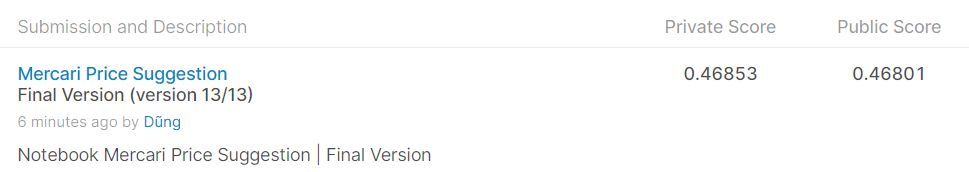